In [67]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg

# Define a function with two poles that is normalized between -1 and 1

In [4]:
def extremal_rational(u: float, v: float, x) -> np.ndarray:
    """
    Compute f(x) = A/(x+u) + B/(x+v) with:
      • u, v > 0 and u != v
      • v is a stationary point: f'(v) = 0
      • normalized so that f(v) = 1

    Parameters
    ----------
    u, v : positive floats with u != v
    x    : array-like of evaluation points

    Returns
    -------
    np.ndarray of f(x) values.
    """
    if not (u > 0 and v > 0):
        raise ValueError("u and v must be positive.")
    if np.isclose(u, v):
        raise ValueError("u and v must be different (cannot set v as an extremum when u = v).")

    # Closed form that avoids forming A and B separately:
    # A = (u+v)**2 / (u - v),  B = -4*v**2 / (u - v)
    x = np.asarray(x, dtype=float)
    num = (u + v)**2 / (x + u) - (2 * v)**2 / (x + v)
    den = (u - v)
    return num / den

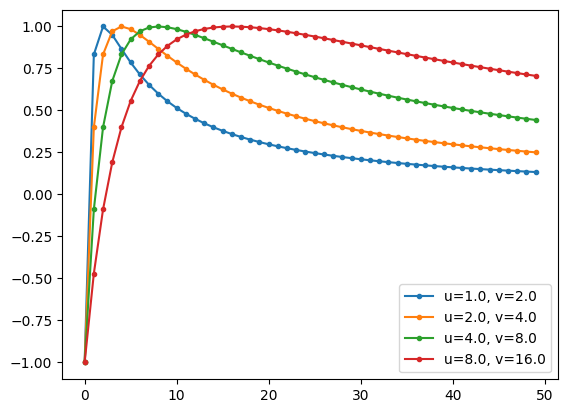

In [ ]:
poles = 2. ** np.arange(5)
xs = np.arange(50)
for u, v in zip(poles[:-1], poles[1:]):
    plt.plot(xs, extremal_rational(u, v, xs), marker='o', markersize=3, label=f"u={u}, v={v}")
plt.legend()
plt.show()

In [56]:
def atom_vandermonde(poles, xs):
    n_funcs = len(poles)
    funcs = np.zeros((n_funcs, len(xs)))
    for i in range(n_funcs):
        if i == 0:
            funcs[i, :] = poles[i] / (xs + poles[i])
        else:
            funcs[i, :] = extremal_rational(poles[i - 1], poles[i], xs)
    return funcs

# Analyze gram matrix

In [ ]:
def gram_matrix(poles, alpha=1, beta=2, n_max=1000000):
    r"""
    Compute the Gram between functions on non-negative integers with power-law weights
        .. math::
            w(x) = \frac{1}{(x + \alpha)^{\beta}}

    The functions are:
        f_0(x) = \frac{p_0}{x + p_0}
        f_k(x) = \frac{A_k}{x + p_k} + \frac{B_k}{x + p_{k+1}},  k = 0, ..., n-1

    where :math:`p_k` is the k-th pole, and :math:`A_k` and :math:`B_k` are chosen such that :math:`f_k` has a local
    maximum at :math:`p_{k+1}`, with :math:`f_k(p_{k+1}) = 1`.

    Parameters
    ----------
    poles : array-like
        The poles of the rational functions to compute the Gram matrix for.
    alpha : float
        The alpha parameter for the weight function
    beta : float
        The beta parameter for the weight function.
    n_max : int
        The maximum number of points to approximate the infinite sum in the inner product's definition.

    Returns
    -------
    np.ndarray
        The computed Gram matrix.
    """
    xs = np.arange(n_max)
    funcs = rational_vandermonde(poles, xs)
    weights = 1 / (xs + alpha) ** beta
    return (funcs * weights[np.newaxis, :]) @ funcs.T


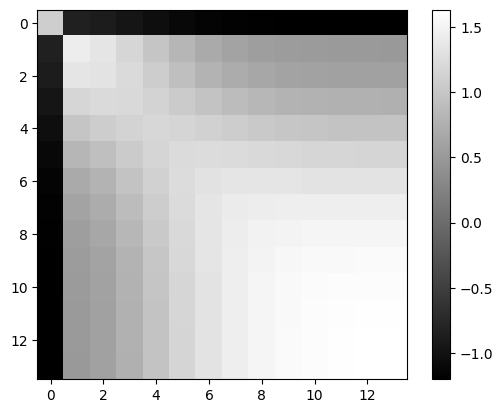

In [60]:
geom_poles = 2 ** np.arange(14)
plt.imshow(gram_matrix(geom_poles), cmap='gray')
plt.colorbar()
plt.show()

# Cholesky orthogonalized basis

In [169]:
geom_poles = 2 ** np.arange(10)
alpha = 1
beta = 2

In [170]:
mat = gram_matrix(geom_poles, alpha=alpha, beta=beta)
chol = np.linalg.cholesky(mat, upper=True)

In [171]:
plot_xs = np.arange(20000)
atom_vander = atom_vandermonde(geom_poles, plot_xs)
ortho_vander = scipy.linalg.solve(chol.T, atom_vander, lower=True)

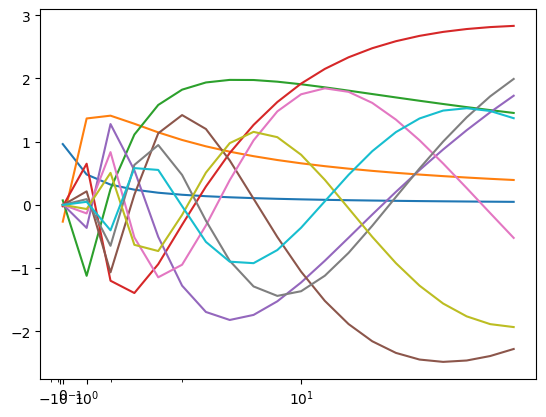

In [178]:
plt.plot(ortho_vander.T[:20])
plt.xscale('asinh', linear_width=100)
plt.show()

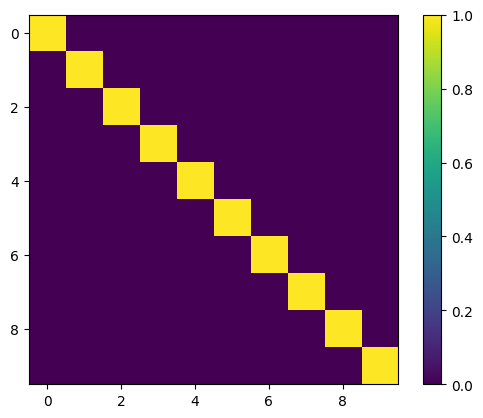

In [173]:
ortho_gram = (ortho_vander / (plot_xs[np.newaxis, :] + alpha) ** beta) @ ortho_vander.T
plt.imshow(np.abs(ortho_gram))
plt.colorbar()
plt.show()